# Imports

In [ ]:
import pyxdf
import pandas as pd
import numpy as np
from glob import glob
import datetime
import matplotlib.pyplot as plt
import sys
import os
# Add the parent directory to the path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("utils"), '..')))
from utils import *

In [ ]:
# Load data for each participant
all_data = {}
for sub_number in range(len(sub_files)): 
    xdf_path = sub_files[sub_number]
    data, header = pyxdf.load_xdf(xdf_path)
    all_data[sub_number] = data


In [55]:
# make df for each modality
all_et_dfs = {}
all_mic_dfs = {}
all_stim_dfs = {}
all_physio_dfs = {}
all_video_dfs = {}
all_eeg_dfs = {}

sub_names = {}

for sub_number in range(len(sub_files)): 
    sub_names[sub_number] = sub_files[sub_number].split('/')[4].split('-')[1]
    streams_collected = [stream['info']['name'][0] for stream in all_data[sub_number]]

    # ET data
    ET = all_data[sub_number][streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    et_df['diff'] = et_df['lsl_time_stamp'].diff()
    all_et_dfs[sub_number] = et_df

    # stim
    stim_dat = all_data[sub_number][streams_collected.index('Stimuli_Markers')]
    stim_df = pd.DataFrame(stim_dat['time_series'])
    stim_df.rename(columns={0: 'trigger'}, inplace=True)
    story_onsets = [20, 30, 40, 50, 60, 70]
    stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
    stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
    stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
    stim_df['diff'] = stim_df['lsl_time_stamp'].diff()
    all_stim_dfs[sub_number] = stim_df

    # mic
    mic_data = all_data[sub_number][streams_collected.index('Microphone')]
    mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
    mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
    mic_df['lsl_time_stamp'] = mic_data['time_stamps']
    mic_df['diff'] = mic_df['lsl_time_stamp'].diff()
    all_mic_dfs[sub_number] = mic_df

    # video
    cam_data = all_data[sub_number][streams_collected.index('WebcamStream')]
    cam_data['time_series'][0]
    frame_nums = [int(i[0]) for i in cam_data['time_series']]
    time_pre = [float(i[1]) for i in cam_data['time_series']]
    time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
    time_post = [float(i[3]) for i in cam_data['time_series']]
    cam_df = pd.DataFrame({'frame_num': frame_nums, 
                        'time_pre': time_pre, 
                        'cap_time_ms': time_evnt_ms,
                        'time_post': time_post,
                        'lsl_time_stamp': cam_data['time_stamps']})

    cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
    cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
    cam_df['diff'] = cam_df['lsl_time_sec'].diff()
    all_video_dfs[sub_number] = cam_df


    # eeg
    eeg_dat = all_data[sub_number][streams_collected.index('EGI NetAmp 0')]
    eeg_df = pd.DataFrame(eeg_dat['time_series'])
    eeg_df['lsl_time_stamp'] = eeg_dat['time_stamps']
    eeg_df['diff'] = eeg_df['lsl_time_stamp'].diff()
    all_eeg_dfs[sub_number] = eeg_df

    # physio
    PS = all_data[sub_number][streams_collected.index('OpenSignals')]
    column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
    ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
    ps_df['lsl_time_stamp'] = PS['time_stamps']
    ps_df['diff'] = ps_df['lsl_time_stamp'].diff()
    all_physio_dfs[sub_number] = ps_df
    
    

# Data Loss Graphs

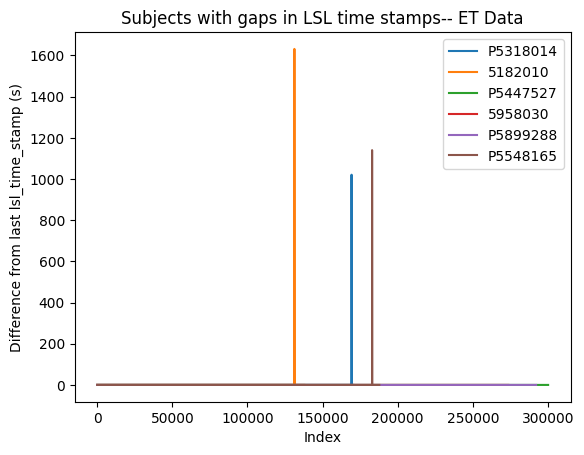

In [152]:
for sub_number in range(len(sub_files)):
    plt.plot(all_et_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- ET Data")
plt.legend()
plt.show()

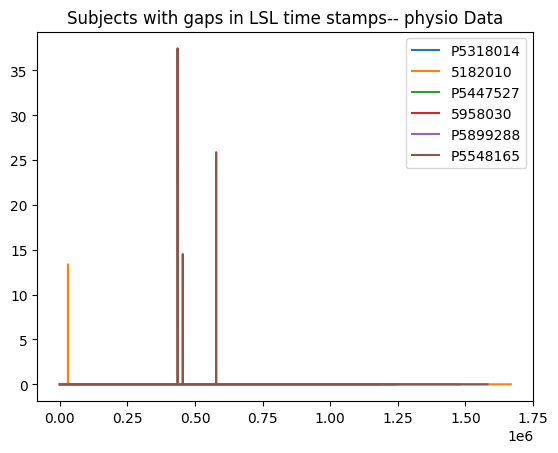

In [ ]:
for sub_number in range(len(sub_files)):
    plt.plot(all_physio_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- Physio Data")
plt.legend()
plt.show()

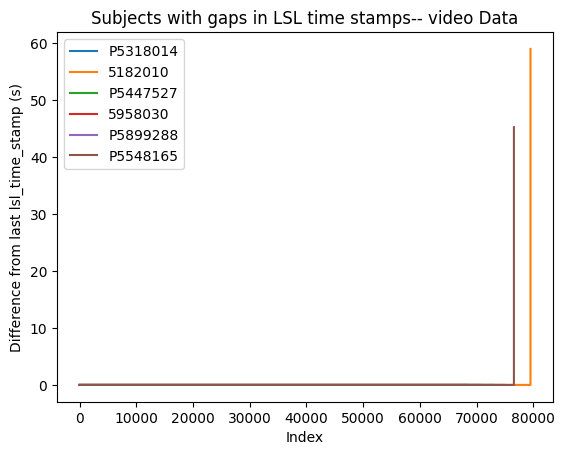

In [153]:
for sub_number in range(len(sub_files)):
    plt.plot(all_video_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- video Data")
plt.legend()
plt.show()

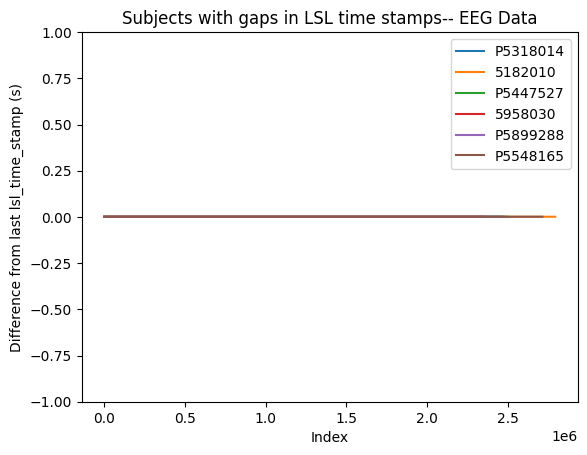

In [158]:
for sub_number in range(len(sub_files)):
    plt.plot(all_eeg_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylim(-1,1)
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')


plt.title("Subjects with gaps in LSL time stamps-- EEG Data")
plt.legend()
plt.show()

In [ ]:
# this makes the kernel crash, do not run
# for sub_number in range(len(sub_files)):
#     plt.plot(all_mic_dfs[sub_number]['diff'], label = sub_names[sub_number])
#     plt.ylim(-1,1)
#     plt.ylabel('Difference from last lsl_time_stamp (s)')
#     plt.xlabel('Index')

# plt.title("Subjects with gaps in LSL time stamps-- mic Data")
# plt.legend()
# plt.show()

# LSL_time_stamp plots

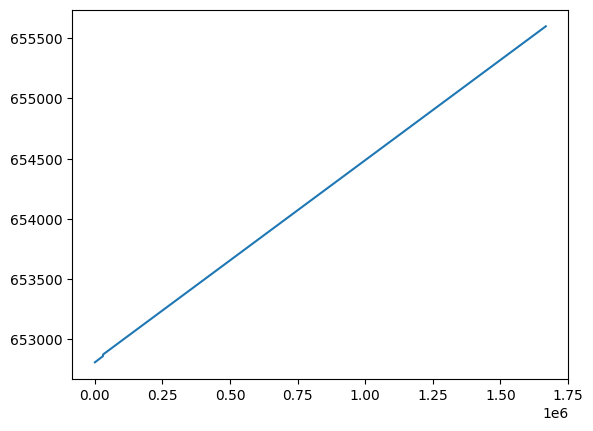

In [80]:
plt.plot(all_physio_dfs[1]['lsl_time_stamp'])

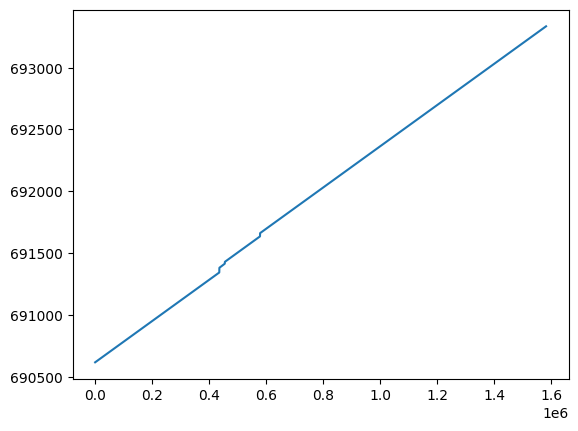

In [81]:
plt.plot(all_physio_dfs[5]['lsl_time_stamp'])

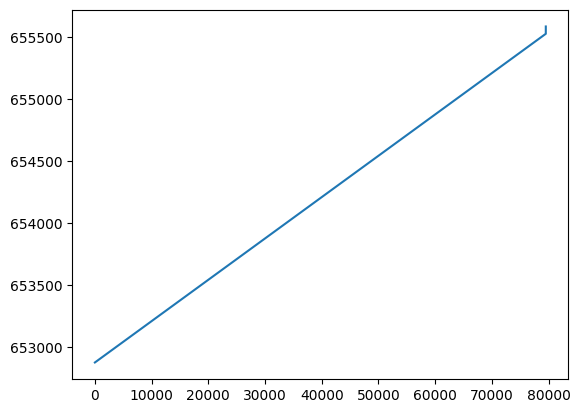

In [82]:
plt.plot(all_video_dfs[1]['lsl_time_stamp'])

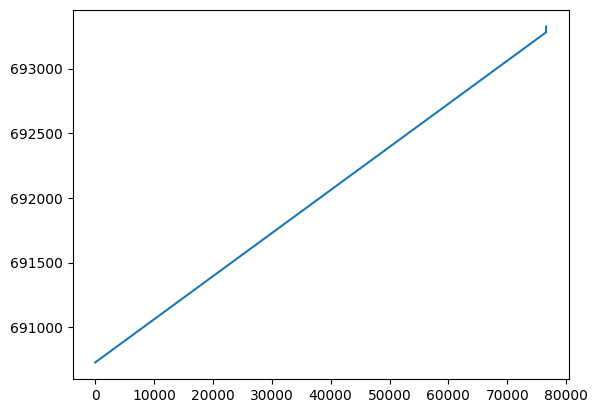

In [83]:
plt.plot(all_video_dfs[5]['lsl_time_stamp'])

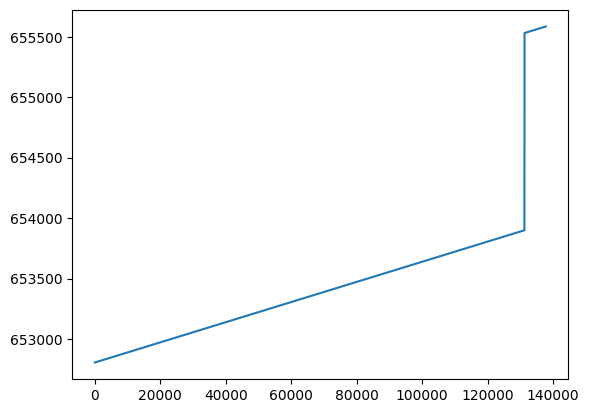

In [84]:
plt.plot(all_et_dfs[1]['lsl_time_stamp'])

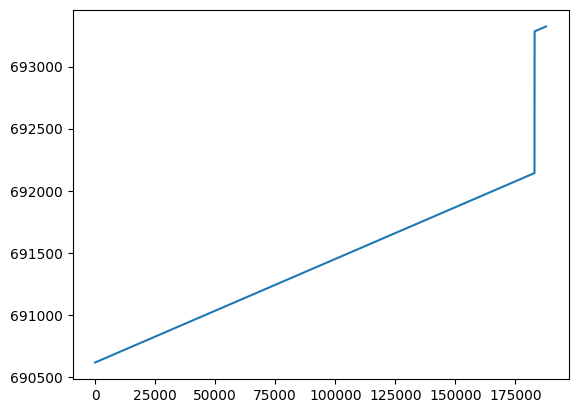

In [ ]:
plt.plot(all_et_dfs[5]['lsl_time_stamp'], label = sub_names[sub_number])

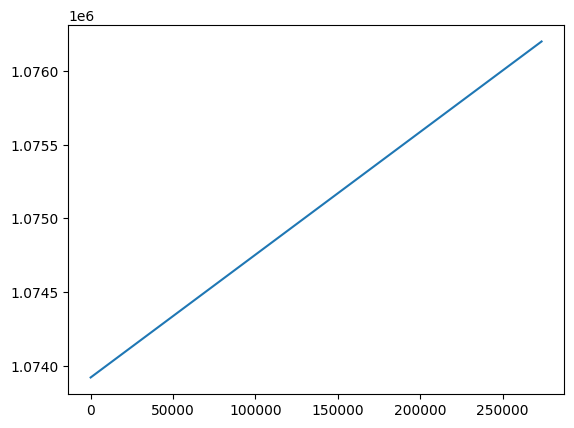

In [ ]:
plt.plot(all_et_dfs[3]['lsl_time_stamp'], label = sub_names[sub_number])

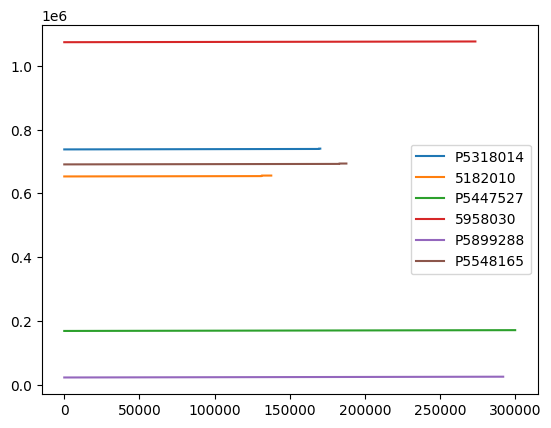

In [ ]:
# plotting them together doesnt work bc different axes
# for sub_number in range(len(sub_files)):
#     plt.plot(all_et_dfs[sub_number]['lsl_time_stamp'], label = sub_names[sub_number])

# plt.legend()


# Percentage of missing data 

In [47]:
all_et_dfs[6]

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,diff
0,1.218497e+12,0.0,1.0,NaN,NaN,NaN,2.624114,-36.399647,519.753906,NaN,...,NaN,NaN,0.307082,0.414526,0.0,1.0,NaN,4.679367,203612.980661,NaN
1,1.218497e+12,0.0,1.0,NaN,NaN,NaN,2.728450,-36.409603,519.716187,NaN,...,NaN,NaN,0.291512,0.421293,0.0,1.0,NaN,4.683838,203612.988995,0.008334
2,1.218497e+12,0.0,1.0,NaN,NaN,NaN,2.912580,-36.384659,519.693726,NaN,...,NaN,NaN,0.295440,0.423865,0.0,1.0,NaN,4.678055,203612.997329,0.008334
3,1.218497e+12,0.0,1.0,NaN,NaN,NaN,3.101953,-36.337723,519.707947,NaN,...,NaN,NaN,0.293449,0.424860,0.0,1.0,NaN,4.676483,203613.005662,0.008334
4,1.218497e+12,0.0,1.0,NaN,NaN,NaN,3.287618,-36.276867,519.715332,NaN,...,NaN,NaN,0.291389,0.417686,0.0,1.0,NaN,4.675003,203613.013996,0.008334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263456,1.220871e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,205986.878482,0.008334
263457,1.220871e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,205986.886816,0.008334
263458,1.220871e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,205986.895149,0.008334
263459,1.220871e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,205986.903483,0.008334


In [48]:
# percent of data lost for one sub, one modality

# median diff between lsl_time_stamp (with 1.05 margin) 
median1 = all_et_dfs[6]['diff'].median() * 1.05

# number of loss instances 
loss_instances = (all_et_dfs[6]['diff'] > median1).sum()

if loss_instances != 0:
    # amount of data skipped: values for which diff>median 
    amt_data_lost = all_et_dfs[6].loc[all_et_dfs[6]['diff'] > median1, 'diff'].values[0].sum()
    # total amount of data: last - first lsl_time_stamp
    amt_data_total = all_et_dfs[6]['lsl_time_stamp'].values[-1] - all_et_dfs[6]['lsl_time_stamp'].values[0]

    percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
else:
    percent_lost = 0

print(percent_lost,"%")



7.513 %


In [49]:
sub_files

['../../../Data/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5287460/sub-P5287460_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5813427/sub-P5813427_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5070899/sub-P5070899_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [56]:
# df with percent loss for each sub, each modality
modalities = ['et', 'physio', 'mic', 'video', 'eeg']
percent_list = []

for sub_number in range(len(sub_files)):
    timestamp = int(all_stim_dfs[sub_number].loc[all_stim_dfs[sub_number]['event'] == 'psychopy_time_stamp', 'trigger'].iloc[0])
    date_object = datetime.datetime.fromtimestamp(timestamp)
    date_string = date_object.strftime("%Y-%m-%d")
    
    for modality in modalities:
        df = globals()['all_'+modality+'_dfs'][sub_number]
        subject = sub_names[sub_number]
        
        # median diff between lsl_time_stamp (with 1.05 margin) 
        median1 = df['diff'].median() * 1.05
        # number of loss instances  
        loss_instances = (df['diff'] > median1).sum()
        if loss_instances != 0:
            # amount of data skipped: values for which diff>median 
            amt_data_lost = df.loc[df['diff'] > median1, 'diff'].values[0].sum()
            # total amount of data: last - first lsl_time_stamp
            amt_data_total = df['lsl_time_stamp'].values[-1] - df['lsl_time_stamp'].values[0]

            percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
        else:
            percent_lost = 0
        percent_list.append({'sub_num':sub_number, 'date': date_string, 'subject': subject, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss = pd.DataFrame(percent_list)

In [57]:
percent_data_loss.sort_values(by='date', inplace=True, ascending=True)
percent_data_loss


,sub_num,date,subject,modality,num_losses,percent_lost
39,7,2024-10-08,P5548165,eeg,0,0.000
37,7,2024-10-08,P5548165,mic,0,0.000
36,7,2024-10-08,P5548165,physio,3,1.379
35,7,2024-10-08,P5548165,et,1,42.149
38,7,2024-10-08,P5548165,video,1,1.739
5,1,2024-10-16,5182010,et,1,58.696
6,1,2024-10-16,5182010,physio,1,0.478
7,1,2024-10-16,5182010,mic,0,0.000
8,1,2024-10-16,5182010,video,1,2.174
9,1,2024-10-16,5182010,eeg,0,0.000


In [58]:
nonzero_loss = percent_data_loss[percent_data_loss['percent_lost'] != 0]
nonzero_loss

,sub_num,date,subject,modality,num_losses,percent_lost
36,7,2024-10-08,P5548165,physio,3,1.379
35,7,2024-10-08,P5548165,et,1,42.149
38,7,2024-10-08,P5548165,video,1,1.739
5,1,2024-10-16,5182010,et,1,58.696
6,1,2024-10-16,5182010,physio,1,0.478
8,1,2024-10-16,5182010,video,1,2.174
0,0,2024-10-17,P5318014,et,1,41.820
11,2,2025-02-17,P5287460,physio,1,1.033
